# Calling the Instance Segmentation deployed model

In [1]:
import base64
import json
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from azure.ai.ml import automl
from azure.ai.ml import MLClient
from azure.ai.ml.automl import SearchSpace, InstanceSegmentationPrimaryMetrics
from azure.ai.ml.sweep import (Choice, Uniform, BanditPolicy,)
from azure.identity import DefaultAzureCredential
from IPython.display import Image
from matplotlib.lines import Line2D
from PIL import Image as PILimage

%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
credential = DefaultAzureCredential()

ml_client = None
try:
    ml_client = MLClient.from_config(credential)

except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace = "<AML_WORKSPACE_NAME>"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

Found the config file in: /config.json


In [4]:
online_endpoint_name = "instance02082001616136"

In [5]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'instance-mlflow-model-dpl': 100}
https://instance02082001616136.westeurope.inference.ml.azure.com/score


In [6]:
def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()

In [25]:
def get_predictions():
    """
    Get predictions
    """
    request_json = {
        "input_data": {
            "columns": ["image"],
            "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
        }
    }

    request_file_name = "sample_request_data.json"

    with open(request_file_name, "w") as request_file:
        json.dump(request_json, request_file)

    resp = ml_client.online_endpoints.invoke(
        endpoint_name=online_endpoint_name,
        deployment_name="instance-mlflow-model-dpl",
        request_file=request_file_name,
    )
    
    return resp

In [34]:
def view_predictions(minconf=0.5):
    """
    Viewing predictions
    """
    img_np = mpimg.imread(sample_image)
    img = PILimage.fromarray(img_np.astype("uint8"), "RGB")
    x, y = img.size

    fig, ax = plt.subplots(1, figsize=(15, 15))

    ax.imshow(img_np)
    nb_product = 0

    print("AutoML for instance segmentation results:\n")

    detections = json.loads(resp)[0]

    for detect in detections["boxes"]:
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]

        if conf_score >= minconf:
            ymin, xmin, ymax, xmax = (
                box["topY"],
                box["topX"],
                box["bottomY"],
                box["bottomX"],
            )
            topleft_x, topleft_y = x * xmin, y * ymin
            width, height = x * (xmax - xmin), y * (ymax - ymin)
            print(nb_product+1, "label:", label, "=", conf_score)
        
            if label == 'carton':
                color = "brown"

            if label == 'milk_bottle':
                color = "lime"

            if label == 'water_bottle':
                color = "cyan"
        
            if label == 'can':
                color = "orange"
            
            polygon_np = np.array(polygon[0])
            polygon_np = polygon_np.reshape(-1, 2)
            polygon_np[:, 0] *= x
            polygon_np[:, 1] *= y
            poly = patches.Polygon(polygon_np, True, facecolor=color, alpha=0.6)
        
            plt.text(np.min(polygon_np), np.max(polygon_np)+25, label + " = " + str(round(conf_score, 3)),
                     color=color, fontsize=20)
        
            ax.add_patch(poly)
            poly_line = Line2D(
                polygon_np[:, 0],
                polygon_np[:, 1],
                linewidth=2,
                marker="o",
                markersize=10,
                color=color,
                markerfacecolor=color,
            )
            ax.add_line(poly_line)
            nb_product += 1

    plt.text(25, 25, "Number of products = " + str(nb_product),
                     color="red", fontsize=25)

    plt.show()

## Testing

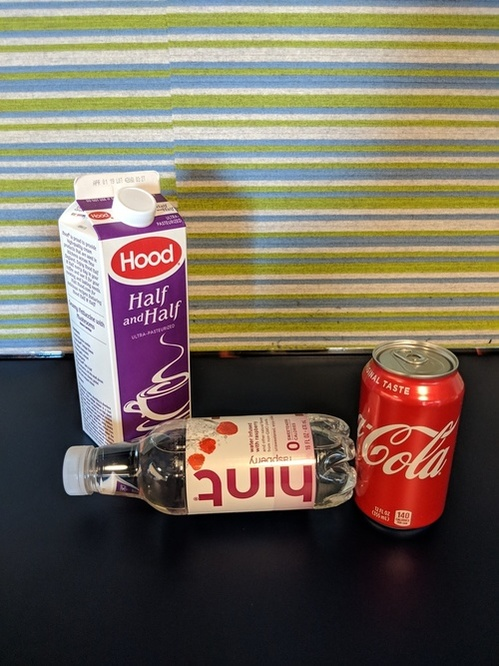

In [35]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "50.jpg")
Image(filename=sample_image, width=360)

In [36]:
resp = get_predictions()

AutoML for instance segmentation results:

1 label: carton = 0.9977385997772217
2 label: water_bottle = 0.9812093377113342
3 label: can = 0.9672799706459045


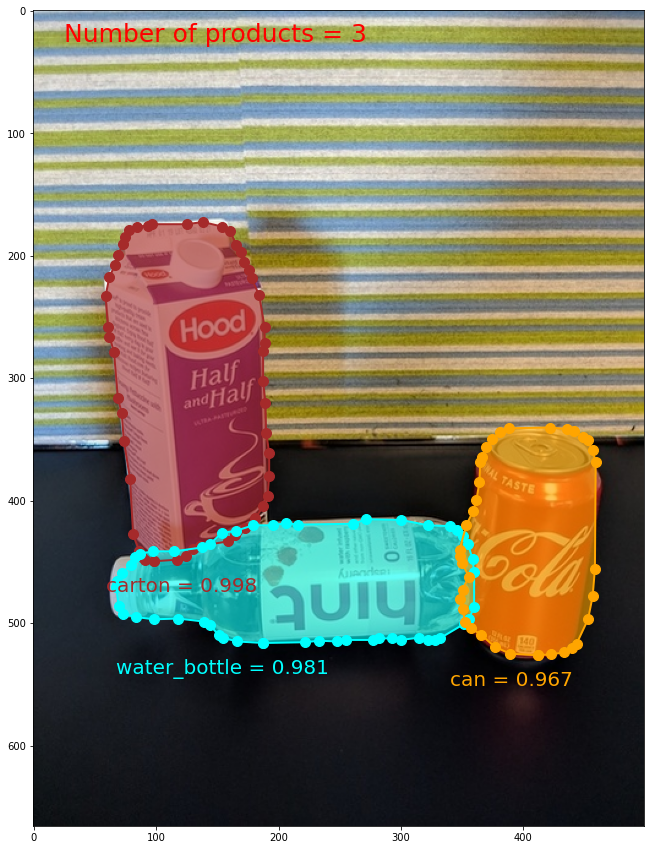

In [37]:
view_predictions(minconf=0.5)

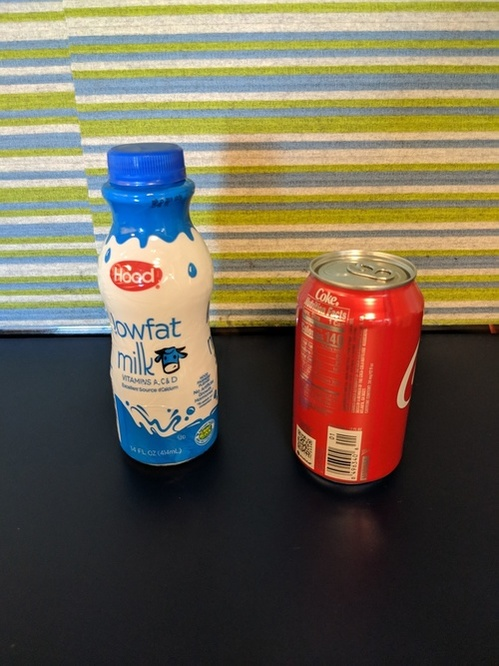

In [38]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "15.jpg")
Image(filename=sample_image, width=360)

In [39]:
resp = get_predictions()

AutoML for instance segmentation results:

1 label: milk_bottle = 0.9975289702415466
2 label: can = 0.9966198205947876


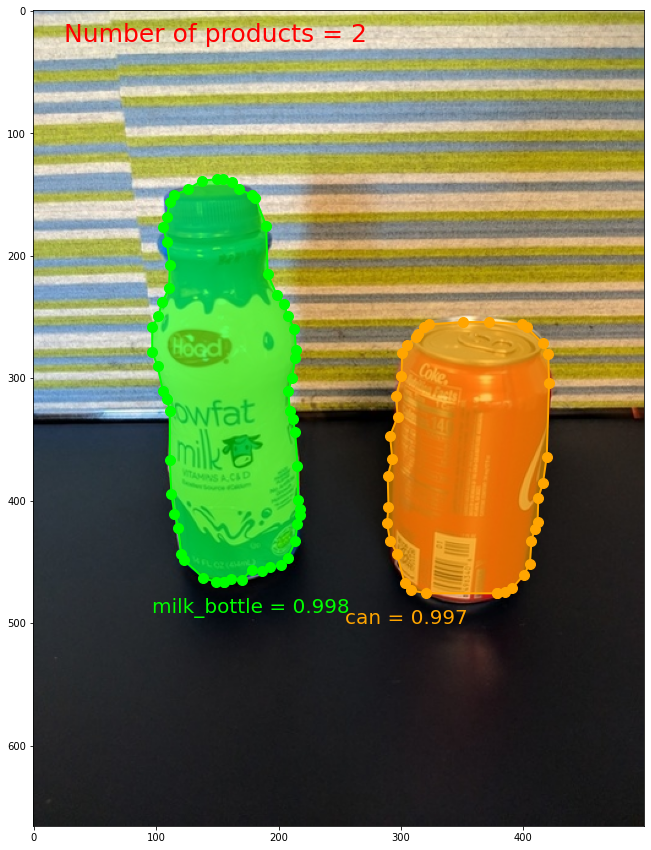

In [40]:
view_predictions(minconf=0.5)

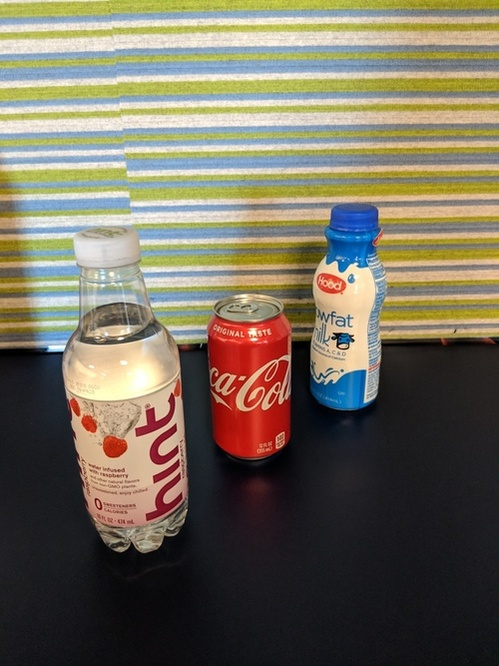

In [44]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "35.jpg")
Image(filename=sample_image, width=360)

In [45]:
resp = get_predictions()

AutoML for instance segmentation results:

1 label: water_bottle = 0.9971241354942322
2 label: can = 0.9736300706863403
3 label: milk_bottle = 0.9668684601783752


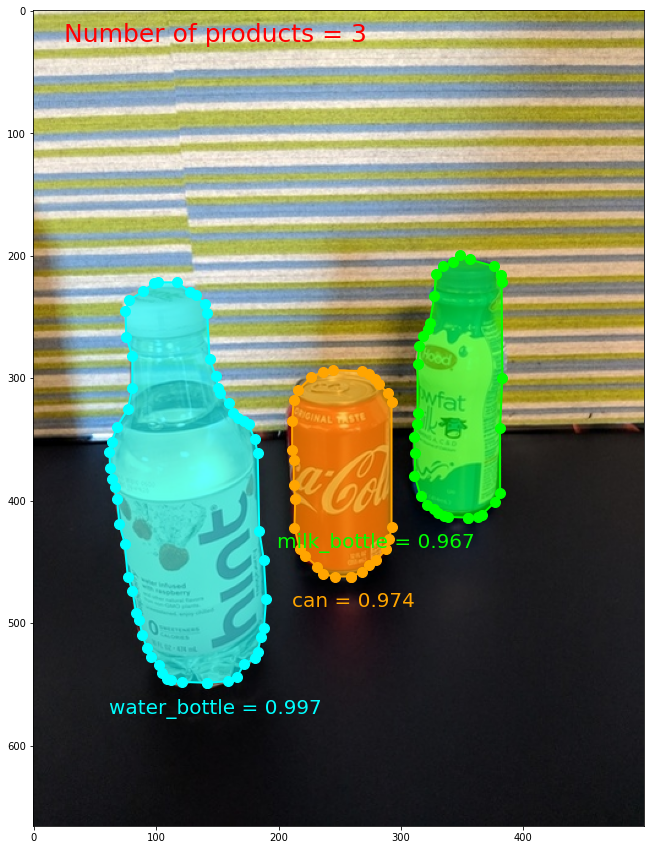

In [46]:
view_predictions(minconf=0.5)